This is a notebook for quantifying the divergence of Colabfold structures from AlphaFold2 structures.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import scipy as sp
from scipy.stats import mannwhitneyu

In [3]:
'''
Create a new column in the dataframe that indicates whether a structure is from a control group or a cluster
'''

# Structures are from the control group if they have a "U1" in their name
def is_control_group(name):
    if 'U1' in name:
        return 'Control'
    else:
        return 'Cluster'

[25.2185 28.785  47.897  50.0965 21.893  17.0355 37.01   15.66    5.1945
 72.18   31.176  30.356  12.838  51.063  27.9865 45.4045 15.859  56.059 ]
Statistics=1615.000, p=0.006


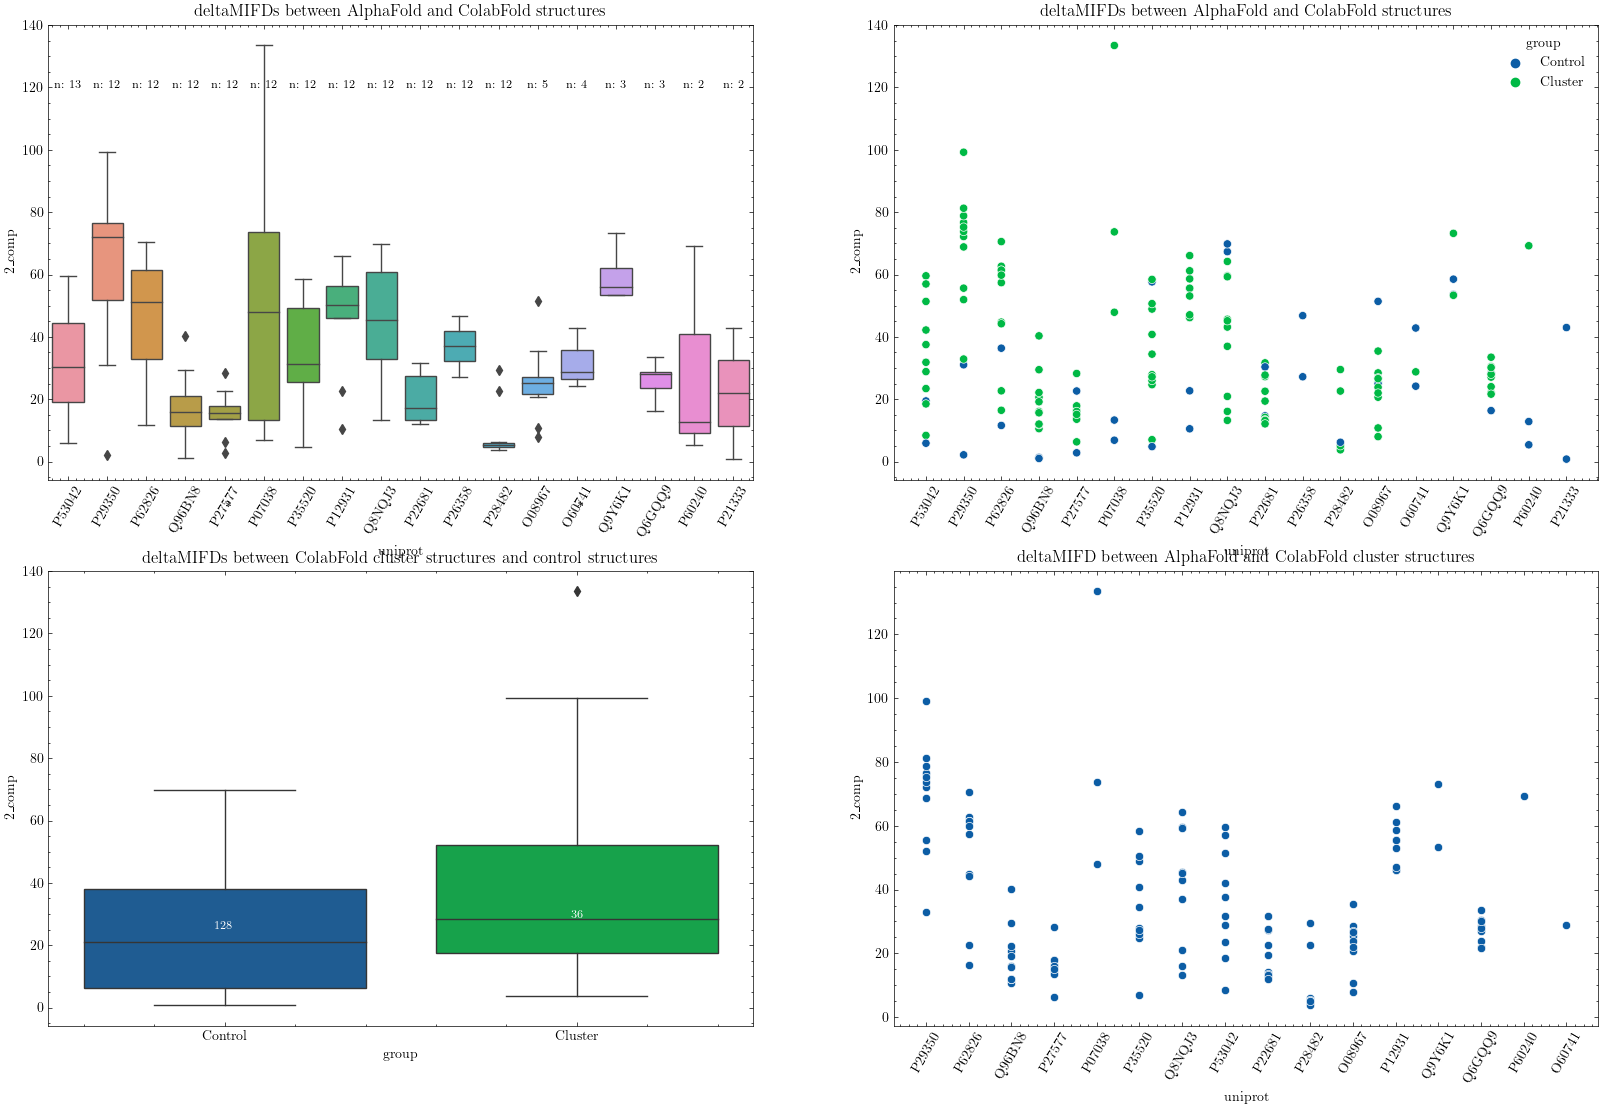

In [4]:
'''
Compare the distribution of deltaMIFD within proteins
'''

df = pd.read_csv('./project_pipeline/data/af_compared.tsv', sep='\t')

# Create a new column that indicates whether a structure is from a control group or a cluster
df['group'] = df['filename'].apply(is_control_group)

# Plot the distribution of 2_comp by uniprot
plt.style.use('science')

fig, ax = plt.subplots(2, 2, figsize=(20, 13))
sns.boxplot(df, y = '2_comp', x = 'uniprot', ax = ax[0][0])
ax[0][0].set_title('deltaMIFDs between AlphaFold and ColabFold structures')

# Calculate number observations per group & median to position labels
medians = df.groupby(['uniprot'])['2_comp'].median().values
print(medians)
nobs = df['uniprot'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ['n: ' + i for i in nobs]

# Position labels above the boxes
pos = range(len(nobs))
for tick, label in zip(pos,ax[0][0].get_xticklabels()):
    ax[0][0].text(pos[tick],
            120,
            nobs[tick],
            horizontalalignment='center',
            size='small',
            color='black',
            weight='semibold')

for tick in ax[0][0].get_xticklabels():
    tick.set_rotation(60)

sns.scatterplot(df, y = '2_comp', x = 'uniprot', hue = 'group', ax = ax[0][1])
ax[0][1].set_title('deltaMIFDs between AlphaFold and ColabFold structures')

# Rotate x-axis labels
for tick in ax[0][1].get_xticklabels():
    tick.set_rotation(60)

sns.boxplot(df, y = '2_comp', x = 'group', ax = ax[1][0])
ax[1][0].set_title('deltaMIFDs between ColabFold cluster structures and control structures')
groupn = df['group'].value_counts().values
groupn = [str(x) for x in groupn.tolist()]
gropun = ['n: ' + i for i in groupn]


pos = range(len(groupn))
for tick, label in zip(pos,ax[1][0].get_xticklabels()):
    ax[1][0].text(pos[tick],
            medians[tick] + 0.03,
            groupn[tick],
            horizontalalignment='center',
            size='small',
            color='w',
            weight='semibold'),

df_clust = df[df['group'] == 'Cluster']

sns.scatterplot(df_clust, y = '2_comp', x = 'uniprot', ax = ax[1][1])
ax[1][1].set_title('deltaMIFD between AlphaFold and ColabFold cluster structures')
for tick in ax[1][1].get_xticklabels():
    tick.set_rotation(60)

'''
Use the Mann-Whitney U test to compare the distribution of deltaMIFD between the control group and the cluster
'''

from scipy.stats import mannwhitneyu

# Compare the distribution of deltaMIFD between the control group and the cluster
control = df[df['group'] == 'Control']['2_comp']
cluster = df[df['group'] == 'Cluster']['2_comp']
stat, p = mannwhitneyu(control, cluster)
print('Statistics=%.3f, p=%.3f' % (stat, p))

'''
Plot the cluster/control plot with significance asterisks
'''

def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

p_asterisk = convert_pvalue_to_asterisks(p)

y_position = df['2_comp'].max() * 1.2
for idx, pval in enumerate(p_asterisk):
    ax[1][0].text(x=idx, y=y_position, s=pval)

plt.savefig('./project_pipeline/data/figures/af_compared.png')

Next we'll analyze the multi-domain proteins and see what their distributions look like compared to the autoinhibitory protein structures.

[164  39]


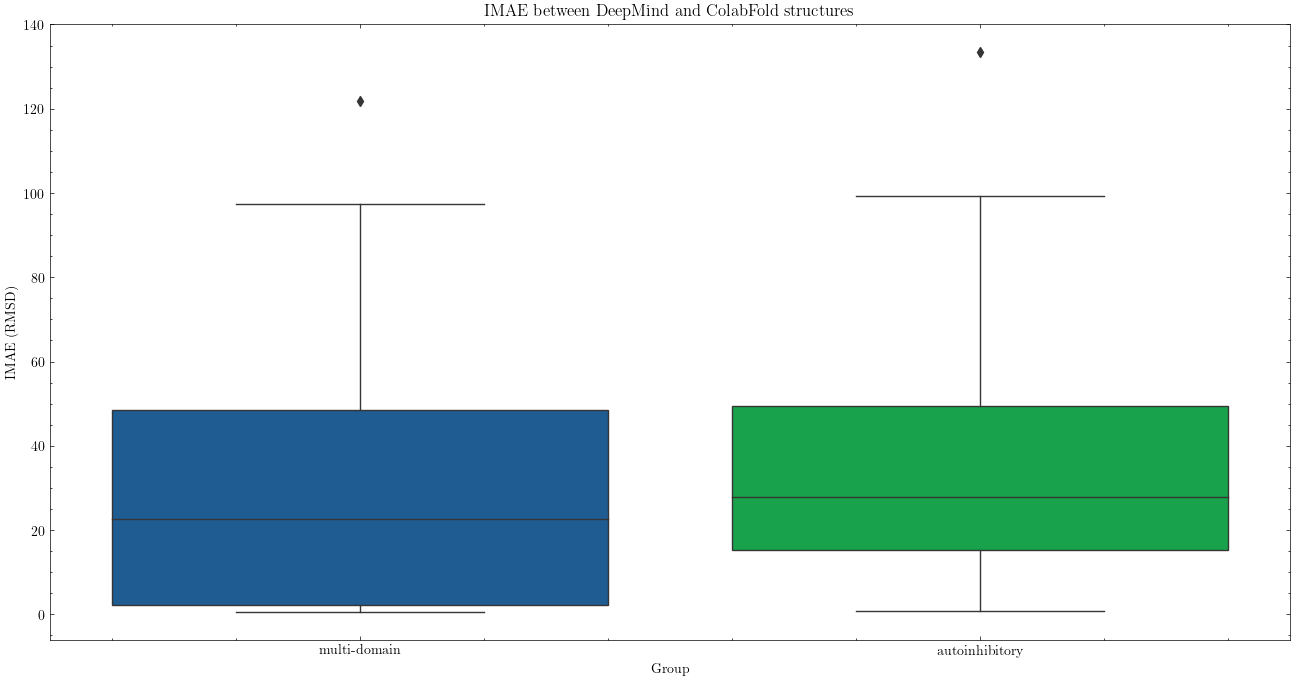

In [27]:
md = pd.read_csv('./project_pipeline/data/md_compared.tsv', sep='\t').astype('object')
ai = pd.read_csv('./project_pipeline/data/af_compared.tsv', sep='\t').astype('object')

# Plot the distribution of 2_comp by uniprot
plt.style.use('science')

# Merge the dataframes and indicate which group each structure belongs to
md['group'] = 'multi-domain'
ai['group'] = 'autoinhibitory'

mg = pd.concat([md, ai])
mg['2_comp'] = pd.to_numeric(mg['2_comp'])

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.boxplot(mg, y = '2_comp', x = 'group', ax = ax)
ax.set_title('IMAE between DeepMind and ColabFold structures')
ax.set_xlabel('Group')
ax.set_ylabel('IMAE (RMSD)')

plt.savefig('./project_pipeline/data/figures/md_vs_ai.png')
group = mg['group'].value_counts().values
print(group)

Test the statistical significance of the distributions

In [23]:
'''
Perform a Mann-Whitney U test to compare the distribution of deltaMIFD between the multi-domain and autoinhibitory structures
'''

# Compare the distribution of deltaMIFD between the multi-domain and autoinhibitory structures
multi_domain = mg[mg['group'] == 'multi-domain']['2_comp']
autoinhibitory = mg[mg['group'] == 'autoinhibitory']['2_comp']
stat, p = mannwhitneyu(multi_domain, autoinhibitory)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=2685.000, p=0.120
